In [1]:
import warnings

import os.path as op
import numpy as np
import cv2

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from ordering_methods import *
from statistical_analysis import *

In [2]:
# prefix = "/work/scratch/malinoro/histogram_transfer/data"
prefix = "/Users/roman/Code/Histogram_transfer/data/"

# Reading or creating images

In [3]:
img1 = cv2.cvtColor(cv2.imread(op.join(prefix, "MiddleBury", "cones.ppm")), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(op.join(prefix, "MiddleBury", "teddy.ppm")), cv2.COLOR_BGR2RGB)
img1 = cv2.resize(img1, dsize=(360, 300))
img2 = cv2.resize(img2, dsize=(360, 300))

## Fake image
X, Y = np.meshgrid(np.linspace(0, 255, img1.shape[1]), np.linspace(0, 255, img1.shape[0]))
R, G, B = np.sqrt((X**2+Y**2)/2), np.sqrt(((255-X)**2+Y**2)/2), np.sqrt(((255-X)**2+(255-Y)**2)/2)
warnings.warn("Using numpy.astype method which always work but can be dependent of OS and other obscure stuff.\nBe sure to check that it casts correctly on your computer")
R, G, B = R.astype(dtype=np.uint8), G.astype(dtype=np.uint8), B.astype(dtype=np.uint8)
img0 = cv2.merge([R, G, B])

/var/folders/kn/x94nsr4955n7vthghm5m3mfw0000gn/T/ipykernel_25229/1955122508.py:9: UserWarning: Using numpy.astype method which always work but can be dependent of OS and other obscure stuff.
Be sure to check that it casts correctly on your computer
  warnings.warn("Using numpy.astype method which always work but can be dependent of OS and other obscure stuff.\nBe sure to check that it casts correctly on your computer")


# Choosing and image, smoothing it, HSV, and separating channels

In [4]:
img = img1
img_ref = img2

# HSV
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
hsv_ref = cv2.cvtColor(img_ref, cv2.COLOR_RGB2HSV)

# Smooth image
img_smooth = cv2.GaussianBlur(img, (5, 5), 0)
hsv_smooth = cv2.GaussianBlur(hsv_img, (5, 5), 0)

# Separating channels
rgb_planes = cv2.split(img)
rgb_ref_planes = cv2.split(img_ref)
rgb_smooth_planes = cv2.split(img_smooth)

hsv_planes = cv2.split(hsv_img)
hsv_ref_planes = cv2.split(hsv_ref)
hsv_smooth_planes = cv2.split(hsv_smooth)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
axes[0,0].imshow(img)
axes[0,1].imshow(img_smooth)

n_bins = 80
for k, c in zip(range(3), ["r", "g", "b"]):
    counts, bins = np.histogram(rgb_planes[k], bins=n_bins, density=True)
    axes[1,0].stairs(counts, bins, color=c)
    axes[1,1].stairs(np.cumsum(counts), bins, baseline=None, color=c)
    
plt.show()


In [7]:
cumulated_hist = False

bins_3d = (20, 20, 20)
X, Y, Z = np.meshgrid(*[np.linspace(0, 255, b) for b in bins_3d])

# This compute the histogram in N dimensions
if cumulated_hist:
    counts, hist = np.histogramdd(np.array(img).reshape(-1, 3), bins=bins_3d)
    counts = counts.cumsum(axis=0).cumsum(axis=1).cumsum(axis=2) / np.sum(counts)
    iso_min, iso_max = 0, 1
else:
    counts, hist = np.histogramdd(np.array(img).reshape(-1, 3), bins=bins_3d, density=True)
    iso_min, iso_max = np.quantile(counts, 0.5), counts.max()

    
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    isomin=iso_min,
    isomax=iso_max,
    value=counts.flatten(),
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))

fig.update_layout(autosize=False, width=500, height=500, scene=dict(xaxis_title='Red', yaxis_title='Green', zaxis_title='Blue'))
fig.show()

### Verifying that the histogram is correctly computed

# Different color spaces

In [5]:
image_BGR = cv2.imread(op.join(prefix, "MiddleBury", "cones.ppm"))
image_LAB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2LAB)
image_HSV = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2HSV)
image_YCrCb = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2YCrCb)
image_LUV = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2Luv)
image_XYZ = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2XYZ)
image_ruderman = cvt_ruderman(image_XYZ)


image_ref_BGR = cv2.imread(op.join(prefix, "MiddleBury", "teddy.ppm"))
image_ref_LAB = cv2.cvtColor(image_ref_BGR, cv2.COLOR_BGR2LAB)
image_ref_HSV = cv2.cvtColor(image_ref_BGR, cv2.COLOR_BGR2HSV)
image_ref_YCrCb = cv2.cvtColor(image_ref_BGR, cv2.COLOR_BGR2YCrCb)
image_ref_LUV = cv2.cvtColor(image_ref_BGR, cv2.COLOR_BGR2Luv)
image_ref_XYZ = cv2.cvtColor(image_ref_BGR, cv2.COLOR_BGR2XYZ)
image_ref_ruderman = cvt_ruderman(image_ref_XYZ)


out_BGR = convert_independent_channels(image_BGR, image_ref_BGR)
out_LAB = convert_independent_channels(image_LAB, image_ref_LAB)
out_HSV = convert_independent_channels(image_HSV, image_ref_HSV)
out_YCrCb = convert_independent_channels(image_YCrCb, image_ref_YCrCb)
out_LUV = convert_independent_channels(image_LUV, image_ref_LUV)
out_XYZ = convert_independent_channels(image_XYZ, image_ref_XYZ)
out_ruderman = convert_independent_channels(image_ruderman, image_ref_ruderman)
out_ruderman = cvt_back_ruderman(out_ruderman)
out_ruderman[np.nonzero(~(out_ruderman>0))] = 0  # removes nan
out_ruderman = np.round(out_ruderman).astype(dtype=out_XYZ.dtype)



out_BGR_RGB = cv2.cvtColor(out_BGR, cv2.COLOR_BGR2RGB)
out_LAB_RGB = cv2.cvtColor(out_LAB, cv2.COLOR_LAB2RGB)
out_HSV_RGB = cv2.cvtColor(out_HSV, cv2.COLOR_HSV2RGB)
out_YCrCb_RGB = cv2.cvtColor(out_YCrCb, cv2.COLOR_YCrCb2RGB)
out_LUV_RGB = cv2.cvtColor(out_LUV, cv2.COLOR_LUV2RGB)
out_XYZ_RGB = cv2.cvtColor(out_XYZ, cv2.COLOR_XYZ2RGB)
out_ruderman_RGB = cv2.cvtColor(out_ruderman, cv2.COLOR_XYZ2RGB)

/Users/roman/Code/Histogram_transfer/statistical_analysis.py:16: RuntimeWarning: divide by zero encountered in log10
  log_LMS = np.log10(img_LMS)
/Users/roman/Code/Histogram_transfer/statistical_analysis.py:20: RuntimeWarning: invalid value encountered in matmul
  ruderman = np.matmul(log_LMS, LMS2ruderman)
/Users/roman/Code/Histogram_transfer/statistical_analysis.py:32: RuntimeWarning: invalid value encountered in matmul
  log_LMS = np.matmul(ruderman, ruderman2LMS)


Text(0.5, 1.0, 'Transfer on Ruderman')

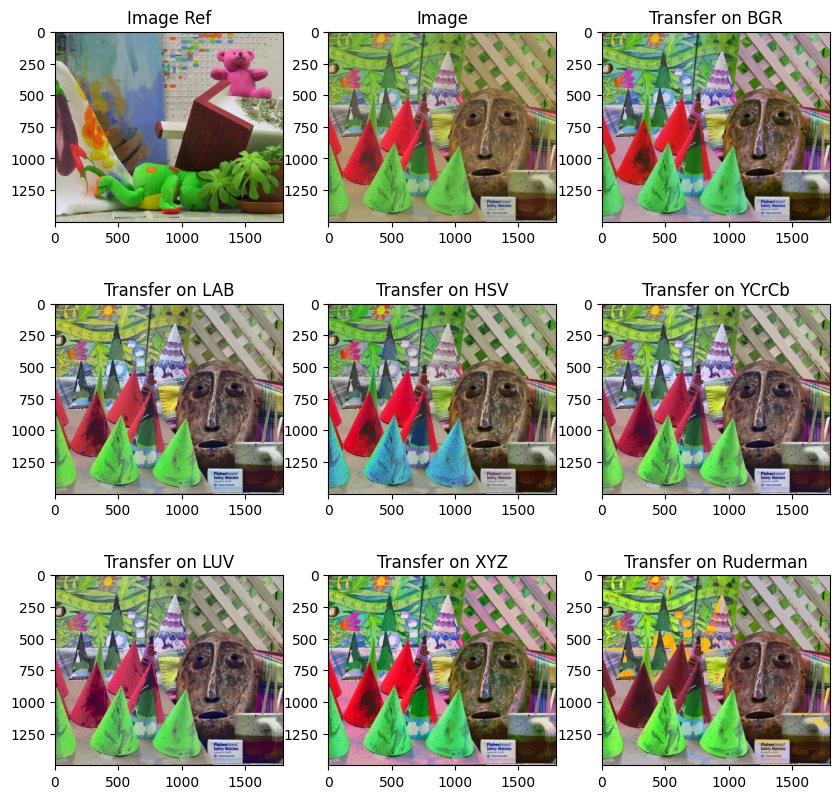

In [6]:
fig, axis = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axis[0,0].imshow(cv2.cvtColor(image_ref_BGR, cv2.COLOR_BGR2RGB))
axis[0,0].set_title("Image Ref")
axis[0,1].imshow(cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB))
axis[0,1].set_title("Image")
axis[0,2].imshow(out_BGR_RGB)
axis[0,2].set_title("Transfer on BGR")
axis[1,0].imshow(out_LAB_RGB)
axis[1,0].set_title("Transfer on LAB")
axis[1,1].imshow(out_HSV_RGB)
axis[1,1].set_title("Transfer on HSV")
axis[1,2].imshow(out_YCrCb_RGB)
axis[1,2].set_title("Transfer on YCrCb")
axis[2,0].imshow(out_LUV_RGB)
axis[2,0].set_title("Transfer on LUV")
axis[2,1].imshow(out_XYZ_RGB)
axis[2,1].set_title("Transfer on XYZ")
axis[2,2].imshow(out_ruderman_RGB)
axis[2,2].set_title("Transfer on Ruderman");

In [16]:
bins_3d = [img]
counts, hist = np.histogramdd(np.array(img).reshape(-1, 3), bins=[])

# TEMP

In [11]:
import pandas as pd

In [5]:
img_transferred = bad_transfer_with_dependence_euclidian(img, img_smooth, img_ref)

InvalidIndexError: ((array([163, 264, 263, ..., 278, 285, 137]), array([202, 288, 290, ...,  14,   1, 296])), slice(None, None, None))

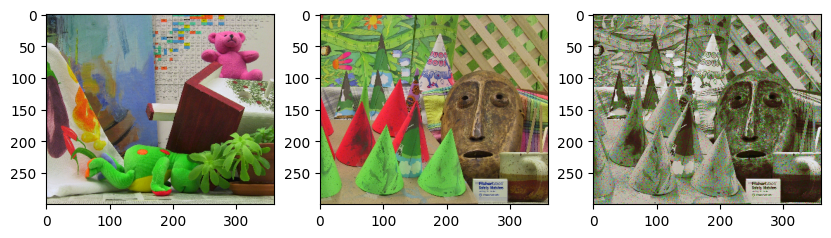

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

axes[0].imshow(img_ref)
axes[1].imshow(img)
axes[2].imshow(img_transferred)

plt.show()

In [9]:
img_transferred = bad_transfer_with_dependence_euclidian(img, img_smooth, img_ref)

NameError: name 'bad_transfer_with_dependence_euclidian' is not defined

True

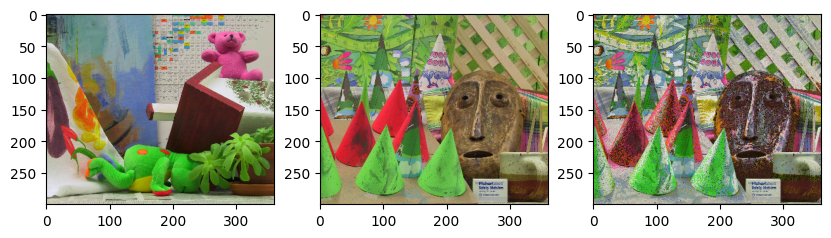

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

axes[0].imshow(img_ref)
axes[1].imshow(img)
axes[2].imshow(img_transferred)

plt.show()